In [1]:
using Pkg; Pkg.activate(".")
using Statistics
using MUST
using PyPlot
using Glob
using DelimitedFiles

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/visualize/Project.toml`


In [2]:
MUST.@import_dispatch "../../../dispatch2" 
MUST.@import_dispatch "../../../dispatch2" EOS 
MUST.@get_help visual
pl =pyimport("matplotlib.pylab");

In [3]:
#folder            = MUST.@in_dispatch "data_testrun4/grid78_phase1"
#folder            = MUST.@in_dispatch "data/stellar"
folder            = MUST.@in_dispatch "data/stellar_relaxing2"

#folder2           = MUST.@in_dispatch "data/stellar_relaxing2"
folder2            = MUST.@in_dispatch "data/restart_relaxing2"
#folder2            = MUST.@in_dispatch "data/restart"

content_of_folder = glob("*/", folder)
snapshots         = sort(MUST.list_of_snapshots(content_of_folder));

content_of_folder2 = glob("*/", folder2)
snapshots2         = sort(MUST.list_of_snapshots(content_of_folder2));

In [4]:
eos_stagger = EOS.stagger(top=MUST.dispatch_location, file="table.dat");

In [5]:
units = MUST.StaggerCGS()

MUST.AtmosUnits("cgs", 1.0e8, 1.0e-7, 100.0, 1.0e6, 1.0e17, 100000.0, 0.09999999999999999, 1.0e12, 100000.0, 0.1, 1.0e-8, 1.3, 1120.9982432795857, 1.380658e-16, 1.6726219e-24, 6.65e-24)

In [6]:
@info """file: data/eos/stagger/table.dat
axis 0: ln(rho)   min=     $(-25.5)  max:      $(6.31)
axis 1: E   min=      $(3.44) step:    0.0243    o:0  n:908 max:      $(25.4)"""

┌ Info: file: data/eos/stagger/table.dat
│ axis 0: ln(rho)   min=     -25.5  max:      6.31
│ axis 1: E   min=      3.44 step:    0.0243    o:0  n:908 max:      25.4
└ @ Main In[6]:1


In [7]:
function convert_snaps(snapshots, folder)
    boxes = []
    for (i_s,snap) in enumerate(snapshots)
        try
            # The dispatch snapshot object (Python)
            snap = dispatch.snapshot(snapshots[i_s], data=folder)

            # Convert its content to pure Julia
            s = MUST.Space(snap, :d, :ee, :uz, :e)
            
            # Units for conversion to CGS
            units = MUST.StaggerCGS(snap)

            # Apply the conversion
            MUST.convert!(s, units; d=:d,   ee=:ee, uz=:u,  e=:e, 
                                    x=:l,   y=:l,   z=:l)
            
            # Also save the snapshot as Box (a regular gridded 3D-cube) to save time later
            b_s = MUST.Box(s)

            append!(boxes, [b_s])

            # Write to HDF5 file. Can easily be read as a Memory map later with the build in functions
            MUST.save(s;   name="space_sn$(snapshots[i_s])", folder=folder)
            MUST.save(b_s; name="box_sn$(snapshots[i_s])",   folder=folder)
        catch
            @warn "sn $(i_s) could not be read."
        end
    end

    boxes
end

convert_snaps (generic function with 1 method)

In [8]:
function read_snaps(snapshots, folder)
    boxes = []
    for (i_s,snap) in enumerate(snapshots)
        try
            # Also save the snapshot as Box (a regular gridded 3D-cube) to save time later
            append!(boxes, [MUST.Box("box_sn$(snapshots[i_s])", folder=folder)])
        catch
            @warn "could not load $(i_s)"
        end
    end
    boxes
end

read_snaps (generic function with 1 method)

In [9]:
boxes = convert_snaps(snapshots, folder)
#boxes = read_snaps(snapshots, folder)
z     = boxes[1].z[1,1,:];

In [11]:
#boxes2 = convert_snaps(snapshots2, folder2)
boxes2 = read_snaps(snapshots2, folder2)
z2     = boxes2[1].z[1,1,:];

┌ Warning: could not load 1
└ @ Main In[8]:8
┌ Warning: could not load 2
└ @ Main In[8]:8


LoadError: BoundsError: attempt to access 0-element Vector{Any} at index [1]

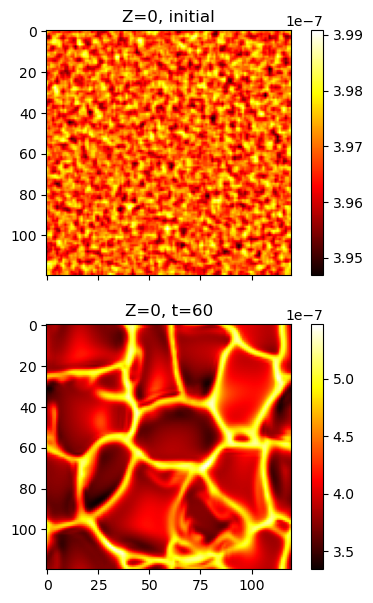

PyObject Text(0.5, 1.0, 'Z=0, t=60')

In [12]:
f,ax = plt.subplots(2,1,sharex=true, sharey=true, figsize=(5,7))

b1  = MUST.reduce_by_value(mean, boxes[2], z=0)
im1 = ax[1].imshow(b1[:d][:,:,1] , cmap="hot")
plt.colorbar(im1,ax=ax[1])
ax[1].set_title("Z=0, initial")

b2  = MUST.reduce_by_value(mean, boxes[end], z=0)
im2 = ax[2].imshow(b2[:d][:,:,1] , cmap="hot")
plt.colorbar(im2, ax=ax[2])
ax[2].set_title("Z=0, t=60")

In [ ]:
#gif_by_value(mean, folder, "z 0 surface", variable=:d, duration=0.35, z=0.0,   path_ext="zp00_nort", cmap="hot")
#gif_by_value(mean, folder2, "z 0 surface", variable=:d, duration=0.35, z=0.0,   path_ext="zp00_rt", cmap="hot")
#gif_by_value(mean, folder, "top",         variable=:uz, duration=0.35, z=0.5,   path_ext="zp05", cmap="hot", vmin=-1,  vmax=1)
#gif_by_value(mean, folder, "inter",       variable=:ee, duration=0.35, z=0.125, path_ext="zp13", cmap="hot", vmin=5.15, vmax=5.55)
#gif_by_value(folder, "bottom", variable=:uz, duration=0.35, z=-1.5e8,  path_ext="zm15", cmap="hot", vmin=0, vmax=20) do x
#    mean(x ./ 1e5)
#end

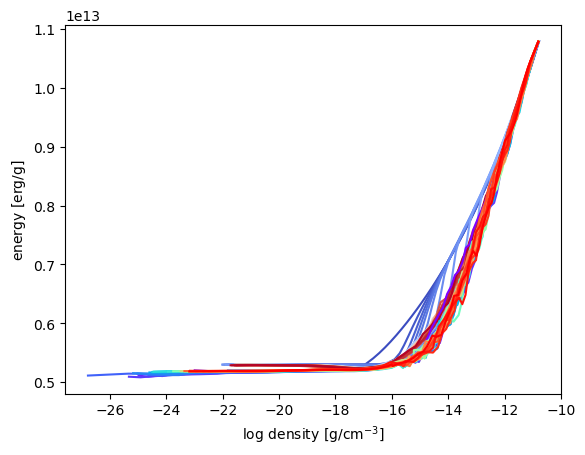

PyObject Text(28.000000000000007, 0.5, '$\\rm energy\\ [erg/g]$')

In [ ]:
f,ax = plt.subplots(1,1)

colors = pl.cm.coolwarm.(Vector(range(0.0,1.0; length=length(boxes))))
sm    = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=0, vmax=length(boxes)))

for i in 1:length(boxes)
    v   = MUST.plane_statistic(x->minimum(log.(x)), boxes[i], :d)
    v2  = MUST.plane_statistic(minimum, boxes[i], :ee)
    zs = boxes[i].z[1,1,:]
    plt.plot(v, v2, label="$(i)", color=colors[i])
end

colors = pl.cm.rainbow.(Vector(range(0.0,1.0; length=length(boxes2))))
sm    = plt.cm.ScalarMappable(cmap="rainbow", norm=plt.Normalize(vmin=0, vmax=length(boxes2)))

for i in 1:length(boxes2)
    v   = MUST.plane_statistic(x->minimum(log.(x)), boxes2[i], :d)
    v2  = MUST.plane_statistic(minimum, boxes2[i], :ee)
    zs = boxes2[i].z[1,1,:]
    plt.plot(v, v2, label="$(i)", color=colors[i])
end

plt.xlabel(L"\rm \log\ density\ [g/cm^{-3}]")
plt.ylabel(L"\rm energy\ [erg/g]")

#plt.legend(ncol=3, fontsize="small")

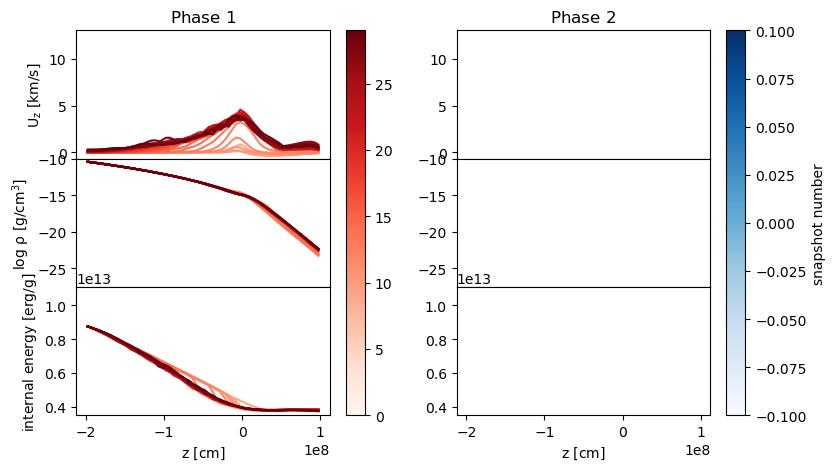

In [16]:
f,ax = plt.subplots(3,2, sharex=true, figsize=(9,5))

plt.subplots_adjust(hspace=0)

filenames = String[]

colors = pl.cm.Reds.(Vector(range(0.3,1.0; length=length(boxes))))
sm     = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=length(boxes)))
plt.colorbar(sm, ax=ax[:,1])

colors2 = pl.cm.Blues.(Vector(range(0.3,1.0; length=length(boxes2))))
sm2     = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=0, vmax=length(boxes2)))
cbar = plt.colorbar(sm2, ax=ax[:,2])
cbar.set_label("snapshot number")

ax[1,2].set_ylim(-0.6736407617187501, 13.025547381103516); ax[1,1].set_ylim(-0.6736407617187501, 13.025547381103516)
ax[2,2].set_ylim(-27.58334445953369, -9.9887113571167)   ; ax[2,1].set_ylim(-27.58334445953369, -9.9887113571167)
ax[3,2].set_ylim(3.5e12, 1.10747040350208e13); ax[3,1].set_ylim(3.5e12, 1.10747040350208e13)

ax[1,1].set_ylabel(L"\rm U_z\ [km/s]")
ax[2,1].set_ylabel(L"\rm \log\ \rho\ [g/cm^3]")
ax[3,1].set_ylabel(L"\rm internal\ energy\ [erg/g]")

ax[3,1].set_xlabel(L"\rm z\ [cm]")
ax[3,2].set_xlabel(L"\rm z\ [cm]")

ax[1,1].set_title(L"\rm Phase\ 1")
ax[1,2].set_title(L"\rm Phase\ 2")


for i in 1:length(boxes)
    v  = MUST.plane_statistic(maximum, boxes[i], :uz) .* 1e-5
    zs = boxes[i].z[1,1,:]
    ax[1,1].plot(zs, v, label="$(i)", color=colors[i])

    v  = MUST.plane_statistic(minimum, boxes[i], :d) 
    zs = boxes[i].z[1,1,:]
    ax[2,1].plot(zs, log.(v), label="$(i)", color=colors[i])

    v  = MUST.plane_statistic(minimum, boxes[i], :ee) 
    zs = boxes[i].z[1,1,:]
    ax[3,1].plot(zs, v, label="$(i)", color=colors[i])

    append!(filenames, ["b1b2_$(i).png"])
    f.savefig("b1b2_$(i).png")
    
    i==1 && f.savefig("ini_snap.png") 
end

#=for i in 1:length(boxes2)
    v  = MUST.plane_statistic(maximum, boxes2[i], :uz) .* 1e-5
    zs = boxes2[i].z[1,1,:]
    ax[1,2].plot(zs, v, label="$(i)", color=colors2[i])

    v  = MUST.plane_statistic(minimum, boxes2[i], :d) 
    zs = boxes2[i].z[1,1,:]
    ax[2,2].plot(zs, log.(v), label="$(i)", color=colors2[i])

    v  = MUST.plane_statistic(minimum, boxes2[i], :ee) 
    zs = boxes2[i].z[1,1,:]
    ax[3,2].plot(zs, v, label="$(i)", color=colors2[i])

    append!(filenames, ["b1b2_$(length(boxes)+i).png"])
    f.savefig("b1b2_$(length(boxes)+i).png")
end=#

#=lim!(a,b) = begin
    lima = a.get_ylim()
    limb = b.get_ylim()
    limm = (min(lima[1],limb[1]), max(lima[2],limb[2]))
    a.set_ylim(limm...)
    b.set_ylim(limm...)
end=#

#=
lim!(ax[1,2], ax[1,1])
lim!(ax[2,2], ax[2,1])
lim!(ax[3,2], ax[3,1])

@show ax[1,2].get_ylim()
@show ax[2,2].get_ylim()
@show ax[3,2].get_ylim()
=#

gif_from_pngs(filenames, "phase_summary_Squaregas.gif")


In [17]:
get_teff(folder) = begin
    path = joinpath(folder, "teff.dat")
    if !ispath(path) @warn "$(path) does not exist."
        return nothing
    end
    data = readdlm(path)
end 

get_teff (generic function with 1 method)

In [18]:
teff = get_teff(folder);

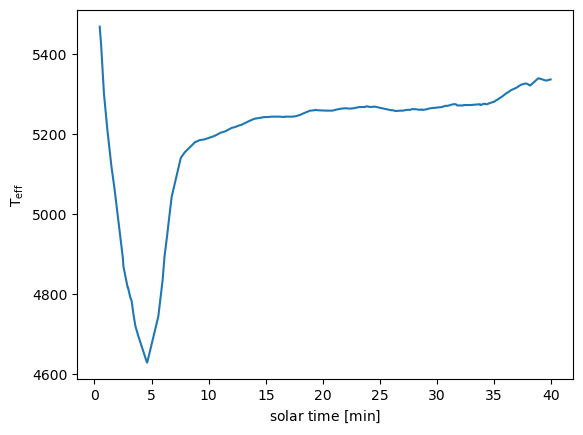

PyObject Text(0.5, 26.28125, '$\\rm solar\\ time\\ [min]$')

In [19]:
plt.plot(teff[:,1], teff[:,2])
plt.ylabel(L"\rm T_{eff}")
plt.xlabel(L"\rm solar\ time\ [min]")